# 高斯过程

In [1]:
from scipy.stats import norm
from matplotlib import pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

高斯过程（Gaussian Process，GP）是将多变量高斯分布推广到无限维度$\mathcal X\subseteq \mathbb R^n$的概率分布。具体地，对于$X = \{x_1, \ldots, x_n\}\subseteq \mathcal X$，随机变量$f(x_1), \ldots, f(x_n)$服从多元高斯分布$\mathcal N(\mu(X), \Sigma(X))$。其中，$\mu(X)$为均值函数，$\Sigma(X)$为协方差函数。因此，高斯分布研究的是函数的概率分布。

多元高斯分布的条件分布依然是高斯分布。设随机变量$X = (X_1, X_2)$服从多元高斯分布$\mathcal N(\mu, \Sigma)$，其中$\mu = (\mu_1, \mu_2)$，$\Sigma = \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{bmatrix}$，则给定$X_1 = x_1$后，$X_2$的条件分布为：

$$
(X_2\mid X_1 = x_1) \sim \mathcal N(\mu_2 + \Sigma_{21}\Sigma_{11}^{-1}(x_1 - \mu_1), \Sigma_{22} - \Sigma_{21}\Sigma_{11}^{-1}\Sigma_{12})
$$

设一组观测数据数据$\boldsymbol X = x_1, \ldots, x_n$及其对应的函数值$\boldsymbol Y = y_1, \ldots, y_n$。对于一个新的数据点$x$，要预测其对应的函数值$y = f(x)$的分布。如果我们能计算出观测数据$\boldsymbol Y$和预测变量$y$之间的协方差，便可以通过高斯分布的条件分布计算得到$f(x)$的均值和方差。

此处令$n = 1$，即$X$取值范围为整个实数域。

In [2]:
def y_posterior(x, x_obs, y_obs, kernel_func):
    # x: (num_features)
    # x_obs: (num_observations, num_features)
    # y_obs: (num_observations)

    sigma_21 = kernel_func(x, x_obs)  # dim: (num_observations)
    sigma_22 = kernel_func(x, x)  # dim: scalar
    # dim: (num_observations, num_observations)
    sigma_11 = kernel_func(x_obs, x_obs)

    inv_11 = np.linalg.inv(sigma_11 + 1e-8 * np.eye(sigma_11.shape[0]))
    mu = np.einsum('i,ij,j->', sigma_21, inv_11, y_obs)
    sigma = sigma_22 - np.einsum('j,jk,k->', sigma_21, inv_11, sigma_21)
    return mu, sigma

def generate_samples(num_samples=5, target_function=None, sigma=1):
    X = np.random.uniform(-5, 5, num_samples).reshape(-1, 1)
    Y = np.random.normal(0, sigma, num_samples)
    if target_function is not None:
        Y += target_function(X)
    return X, Y

def plot_posterior(kernel, num_samples=5, X_obs=None, Y_obs=None, ax=None, grid_size=200):
    if X_obs is None != Y_obs is None:
        raise ValueError('X_obs must be provided if Y_obs is provided.')
    if (X_obs is None or Y_obs is None) and num_samples is None:
        raise ValueError('num_samples must be provided if X_obs is provided.')
    if X_obs is None:
        assert Y_obs is None
        X_obs, Y_obs = generate_samples(num_samples)
    assert X_obs is not None and Y_obs is not None
    if X_obs.shape[0] != Y_obs.shape[0]:
        raise ValueError('The number of observations must be the same.')

    X_min, X_max = np.min(X_obs), np.max(X_obs)
    alpha_95 = norm.ppf(0.975)

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = None

    X = np.linspace(X_min, X_max, grid_size)
    y = [y_posterior(x, X_obs, Y_obs, kernel) for x in X.reshape(-1, 1)]
    ax.plot(X, [y[0] for y in y], linewidth=1, label='Function')
    ax.scatter(X_obs, Y_obs, s=20, label='Observations')
    ax.fill_between(X,
        [y[0] - np.sqrt(y[1]) * alpha_95 for y in y],
        [y[0] + np.sqrt(y[1]) * alpha_95 for y in y],
        alpha=0.5, label='95% CI'
    )

    ax.set_xlabel('x')
    ax.set_xlabel('y')
    ax.legend()
    if fig is not None:
        fig.show()

高斯过程假设更相似的$x$有更相似的$y$，即$\text{Cov}(f(x), f(x')) = d_{x, x'}$。用于描述$x$之间相似度的函数称为**核函数**：$d_{x, x'} = k(x, x')$。核函数的数值越大，说明$x$和$x'$越相似，否则越不相似。

In [3]:
import functools

def kernel_wrapper(*args, **kwargs):
    if args:
        _kernel = args[0]
        if kwargs:
            _kernel = functools.partial(_kernel, **kwargs)

        @functools.wraps(_kernel)
        def new_kernel(a, b):
            if a.shape[-1] != b.shape[-1]:
                raise ValueError('The last dimension of a and b must be the same.')

            num_a = 1 if a.ndim == 1 else a.shape[0]
            num_b = 1 if b.ndim == 1 else b.shape[0]
            num_hidden = a.shape[-1]
            target_shape = (num_a, num_b, num_hidden)

            x_a = np.broadcast_to(a.reshape((num_a, 1, num_hidden)), target_shape)
            x_b = np.broadcast_to(b.reshape((1, num_b, num_hidden)), target_shape)

            result = _kernel(x_a, x_b)
            result_shape = [
                *([] if a.ndim == 1 else [num_a]),
                *([] if b.ndim == 1 else [num_b])
            ]
            result = result.reshape(result_shape)
            return result

        return new_kernel
    else:
        return functools.partial(kernel_wrapper, **kwargs)

# Use the following method to define a kernel function
# @kernel_wrapper - for kernels with no hyperparameters
# @kernel_wrapper(hyperparameter=value) - for kernels with hyperparameters

高斯过程中常用的核函数有：

* 线性核函数：$k(x, x'; v) = vx^Tx'$，其中$v$为超参数。

/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/2131638459.py:48: RuntimeWarning: invalid value encountered in sqrt
  [y[0] - np.sqrt(y[1]) * alpha_95 for y in y],
/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/2131638459.py:49: RuntimeWarning: invalid value encountered in sqrt
  [y[0] + np.sqrt(y[1]) * alpha_95 for y in y],
/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/2131638459.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


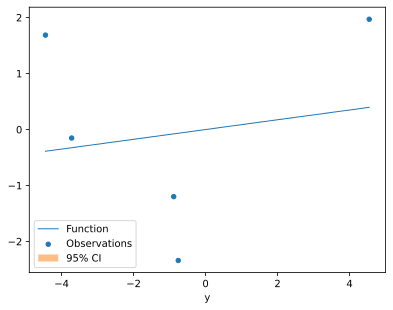

In [4]:
def linear_kernel(a, b, nu=1):
    # Input: a, b: (num_a, num_b, num_hidden)
    return np.einsum('ijk,ijk->ij', a, b) * nu

plot_posterior(kernel_wrapper(nu=1)(linear_kernel), grid_size=10)

* 平方指数核函数：$k(x, x'; \sigma, l) = \sigma^2\exp\left(-\frac{\|x - x'\|^2}{2l^2}\right)$，$\sigma$为幅度参数，控制函数值的随机波动范围；$l$为长度参数，控制函数值的随机波动频率。

/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/2131638459.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


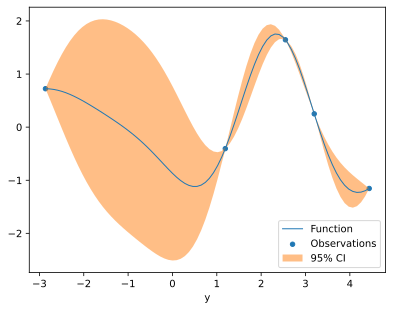

In [5]:
def rbf_kernel(a, b, sigma, l):
    # Input: a, b: (num_a, num_b, num_hidden)
    return sigma ** 2 * np.exp(
        -0.5 * np.linalg.norm(a - b, axis=-1) ** 2 / l ** 2
    )

plot_posterior(kernel_wrapper(sigma=1, l=1)(rbf_kernel), grid_size=80)

* Matern核函数：$k(x, x'; \sigma, l, \nu) = \frac{2^{1-\nu}}{\Gamma(\nu)}\left(\frac{\sqrt{2\nu}\|x - x'\|}{l}\right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\|x - x'\|}{l}\right)$，其中$\nu$为超参数，用于控制函数值的光滑度；$K_\nu$为修正Bessel函数。

/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/497016935.py:6: RuntimeWarning: invalid value encountered in multiply
  y = 2 ** (1 - nu) / gamma(nu) * x ** nu * kn(nu, x)
/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/2131638459.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


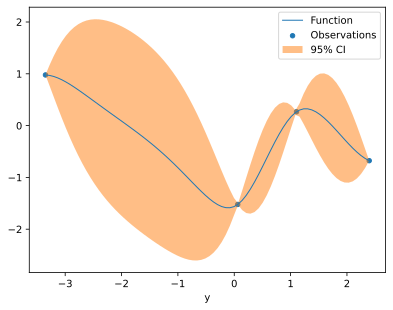

In [6]:
from scipy.special import kn, gamma

def matern_kernel(a, b, l, nu):
    # Input: a, b: (num_a, num_b, num_hidden)
    x = (np.sqrt(2 * nu) * np.linalg.norm(a - b, axis=-1) / l)
    y = 2 ** (1 - nu) / gamma(nu) * x ** nu * kn(nu, x)
    # Replace inf with 1
    y = np.where(x < 1e-6, 1, y)
    return y

plot_posterior(kernel_wrapper(l=1, nu=2)(matern_kernel), 4, grid_size=80)

* 周期核函数：$k(x, x'; \sigma, l, p) = \sigma^2\exp\left(-\frac{2\sin^2(\pi\|x - x'\|/p)}{l^2}\right)$，其中$p$为周期参数，$l$为长度参数，$\sigma$为幅度参数。

/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/2131638459.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


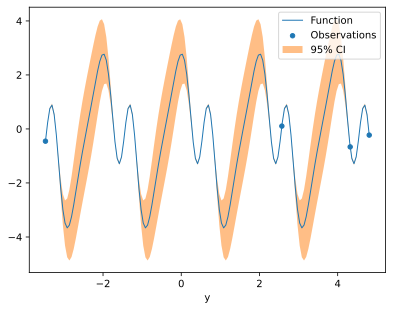

In [7]:
def periodic_kernel(a, b, sigma, l, p):
    # Input: a, b: (num_a, num_b, num_hidden)
    return sigma ** 2 * np.exp(
        -2 * np.sin(np.pi * np.linalg.norm(a - b, axis=-1) / p) ** 2 / l ** 2
    )

plot_posterior(kernel_wrapper(sigma=1, l=1, p=2)(periodic_kernel), 4, grid_size=150)

* 噪声核函数：$k(x, x'; \sigma, l) = \sigma^2\delta_{x, x'}$，其中$\delta_{x, x'}$为Kronecker delta函数，用于捕获观测数据的噪声。

    $$
    \delta(x, x') = \begin{cases}
    1, & x = x' \\
    0, & x \neq x'
    \end{cases}
    $$

/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/2131638459.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


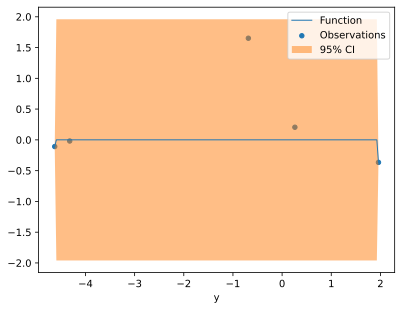

In [8]:
def noise_kernel(a, b, sigma):
    return sigma ** 2 * np.all((a == b), axis=-1)

plot_posterior(kernel_wrapper(sigma=1)(noise_kernel), 5)

在实际应用中，需要根据目标函数已知的特性，设计合适的核函数：如果函数中包含周期性，可以使用周期核函数；如果函数值在相似的$x$之间变化较小，可以使用平方指数核函数。

如对于函数

$$
f(x) = \sin(\pi x) + 0.3 x^2 + \varepsilon
$$

需要同时引入周期核函数和平方指数核函数，才能较好地预测函数值。

/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/4237481582.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


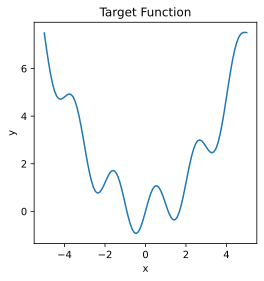

In [9]:
def target_function(X):
    x = X.reshape(-1)
    return np.sin(x * 2 * 3.14 / 2) + x ** 2 * 0.3


def plot_function(func, ax, X_min=-5, X_max=5, grid_size=200, **kwargs):
    X = np.linspace(X_min, X_max, grid_size)
    Y = func(X.reshape(-1, 1))
    ax.plot(X, Y, **kwargs)

fig, ax = plt.subplots(figsize=(4, 4))
plot_function(target_function, ax, grid_size=100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Target Function')
fig.show()

/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/2131638459.py:48: RuntimeWarning: invalid value encountered in sqrt
  [y[0] - np.sqrt(y[1]) * alpha_95 for y in y],
/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/2131638459.py:49: RuntimeWarning: invalid value encountered in sqrt
  [y[0] + np.sqrt(y[1]) * alpha_95 for y in y],
/var/folders/wg/gb8y92_d43j60wvfw6bs_cz00000gn/T/ipykernel_96329/1232705018.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


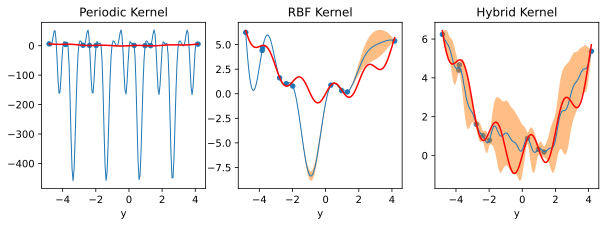

In [10]:
periodic = kernel_wrapper(sigma=1, l=1, p=2)(periodic_kernel)
rbf = kernel_wrapper(sigma=1, l=1)(rbf_kernel)
noise = kernel_wrapper(sigma=0.1)(noise_kernel)

def added(a, b):
    return periodic(a, b) + rbf(a, b) + noise(a, b)

kernels = {
    'Periodic': periodic,
    'RBF': rbf,
    'Hybrid': added
}

X_obs, Y_obs = generate_samples(10, target_function, sigma=0.5)
X_min, X_max = np.min(X_obs), np.max(X_obs)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, (name, kernel) in zip(axes, kernels.items()):
    plot_posterior(kernel, X_obs=X_obs, Y_obs=Y_obs, ax=ax, grid_size=150)
    plot_function(target_function, ax, X_min, X_max, color='red', label='Target Function', grid_size=100)
    ax.set_title(f'{name} Kernel')
    ax.get_legend().remove()
fig.show()

高斯过程不适用于以下场景：

* 数据量较大时，由于计算$m$维矩阵逆的复杂度为$O(m^3)$，计算复杂度较高。
* 数据维度较高时，维度灾难会导致核函数容易退化，无法捕获数据之间的相似性。
* 高斯过程的预测结果是连续的，无法直接处理连续数据。